In [1]:
!python -m pip install --index-url https://support.bayesfusion.com/pysmile-A/ pysmile

Looking in indexes: https://support.bayesfusion.com/pysmile-A/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import itertools
import pysmile
import pprint

from collections import Counter


In [3]:
sns.set_style("whitegrid")

In [4]:
pysmile.License((
	b"SMILE LICENSE 2c4f954d 72216c8d e0e08fa1 "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: 6elhdnh8czmjbetdjhpo4d5vl "
	b"Issued for: Jaime Perez (jaime.perez.sanchez@gmail.com) "
	b"Academic institution: Universidad Pontificia Comillas "
	b"Valid until: 2023-11-17 "
	b"Issued by BayesFusion activation server"
	),[
	0x65,0x83,0x6e,0x39,0x81,0x24,0xbf,0x37,0x03,0x5e,0xb5,0x21,0xf1,0x77,0x2e,0x56,
	0xab,0x6b,0x43,0x35,0x23,0x31,0xa9,0xaf,0x98,0x23,0x48,0xae,0x87,0x60,0x02,0x1c,
	0xf5,0x6e,0x83,0x2d,0x47,0xda,0x5f,0x65,0x10,0xf3,0x4c,0x38,0x7c,0x71,0x19,0x20,
	0x00,0x27,0x04,0x9f,0x53,0x8a,0xe5,0x95,0x27,0xc1,0xa7,0xbd,0xa4,0x2b,0xd0,0xb2])

In [5]:
from google_drive_downloader import GoogleDriveDownloader as gdd


# gdd.download_file_from_google_drive(file_id='1LkG3-BPtIVAgKzFw8Y3ZtqjABnWyGLMw',
#                                    dest_path='./DAG_OG_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1xMCNz9Ay7SID6fHuoOTOshdBGB6VUXAw',
#                                    dest_path='./DAG_FN_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1ofhqAkI6o0DBoVptThBdczvvAvsIuCW4',
#                                    dest_path='./DAG_CT_v2_trained.xdsl',
#                                    unzip=False)

In [ ]:
# gdd.download_file_from_google_drive(file_id='1ejOgdFDoO-DJcBNvb0EznLIq3bDZAAoN',
#                                    dest_path='./data_DAG_OG_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1hEHwxbIxOUBXsfwDBrUNgI7zCHlmxJDd',
#                                    dest_path='./data_DAG_FN_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1p4Pd0M8sdQtcIC3dNrZ3nxdTXSezvK2z',
#                                    dest_path='./data_DAG_CT_v2.csv',
#                                    unzip=False)

In [ ]:
# gdd.download_file_from_google_drive(file_id='1QMo3OQFZRw46wJk6aeXKvdf9hr-hDBj-',
#                                     dest_path='./DAGsData.zip',
#                                     unzip=False)

In [6]:
# !unzip DAGsData.zip

In [ ]:
# import zipfile
# import os

# def unzip_file(zip_file_path, extract_to_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_path)
# unzip_file("DAGsData.zip", "DAGsData")

In [7]:
normalization = math.sqrt(math.log(2))

In [8]:
network_file_OG = "DAG_OG_v2_trained.xdsl"
var_interest_OG = 'OG_risk'

network_file_FN = "DAG_FN_v2_trained.xdsl"
var_interest_FN = 'FN_risk'

network_file_CT = "DAG_CT_v2_trained.xdsl"
var_interest_CT = 'CT_risk'

In [9]:
network_file = "DAG_OG_v2_trained.xdsl"
var_interest = 'OG_risk'

In [10]:
def compute_rank_evidencesv2(num, values, DAG_file, var_interest):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(DAG_file)
  net.update_beliefs()

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    for subgroup in lst_iter:
      net.clear_all_evidence()
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [11]:
def compute_rank_evidences(num, values):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(network_file)
  net.update_beliefs()
  print("ok")

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))
  print("ok2")

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    print(lst_values)
    for subgroup in lst_iter:
      net.clear_all_evidence()
      print(subgroup)
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
        print(group[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [12]:
def plot_var_count_elegant(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  dict_var_names = {'Previous_Victimization0': 'Previous Victimization = False',
                    'Honesty0': 'Honesty = Low',
                    'Honesty1': 'Honesty = Medium Low',
                    'Honesty2': 'Honesty = Medium',
                    'Honesty3': 'Honesty = High',
                    'Neuroticism_BF0': 'Neuroticism = Low',
                    'Neuroticism_BF1': 'Neuroticism = Medium',
                    'Neuroticism_BF2': 'Neuroticism = High',
                    'Conscientiousness_BF0': 'Conscientiousness = Low',
                    'Conscientiousness_BF1': 'Conscientiousness = Medium',
                    'Conscientiousness_BF2': 'Conscientiousness = High',
                    'Agreeableness_BF0': 'Agreeableness = Low',
                    'Agreeableness_BF1': 'Agreeableness = Medium',
                    'Agreeableness_BF2': 'Agreeableness = High',
                    'Introversion_BF0': 'Introversion = Low',
                    'Introversion_BF1': 'Introversion = Medium',
                    'Introversion_BF2': 'Introversion = High',
                    'Openness2Experience_BF0': 'Openness2Experience = Low',
                    'Openness2Experience_BF1': 'Openness2Experience = Medium',
                    'Openness2Experience_BF2': 'Openness2Experience = High',
                  'Previous_Victimization1': 'Previous Victimization = True',
                  'Gender0': 'Gender = Male',
                  'Gender1': 'Gender = Female',
                  'Gender2': 'Gender = Non Binary',
                  'Social_Support0': 'Social Support = Low',
                  'Social_Support1': 'Social Support = Medium',
                  'Social_Support2': 'Social Support = High',
                  'Family_Support0': 'Family Support = Low',
                  'Family_Support1': 'Family Support = Medium',
                  'Family_Support2': 'Family Support = High',
                  'Age0': 'Age = 12',
                  'Age1': 'Age = 13',
                  'Age2': 'Age = 14',
                  'Age3': 'Age = 15',
                  'Age4': 'Age = 16',
                  'Self_Esteem0': 'Self-Esteem = Low',
                  'Self_Esteem1': 'Self-Esteem = Medium',
                  'Self_Esteem2': 'Self-Esteem = High',
                  'Empathy0': 'Empathy = Low',
                  'Empathy1': 'Empathy = High',
                  'Migratory_background0': 'Migratory background = No',
                  'Migratory_background1': 'Migratory background = 2nd Gen.',
                  'Migratory_background2': 'Migratory background = 3rd Gen.',
                  'Sexual_Orientation0': 'Sexual Orientation = Heterosexual',
                  'Sexual_Orientation1': 'Sexual Orientation = Non Heterosexual',
                  'Hours_Internet0': 'Hours Internet = <1h',
                  'Hours_Internet1': 'Hours Internet = 1-2h',
                  'Hours_Internet2': 'Hours Internet = 2-3h',
                  'Hours_Internet3': 'Hours Internet = 3-4h',
                  'Hours_Internet4': 'Hours Internet = >4h'
                  }
  df_count_elegant = df_count.replace(dict_var_names)
  plt.figure(figsize=(10, 7))
  sns.barplot(data=df_count_elegant, x='Percentage', y='Variable', color='tab:blue')

  plt.xlim((0,100))
  # plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
  # plt.xticks(rotation=90)
  plt.show()

In [13]:
def plot_var_count(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Percentage', y='Variable')
  plt.xlim((0,100))

  # plt.xticks(rotation=90)
  plt.show()

In [14]:
def plot_var_count_elegant(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  dict_var_names = {'Previous_Victimization0': 'Previous Victimization = False',
                    'Honesty0': 'Honesty = Low',
                    'Honesty1': 'Honesty = Medium Low',
                    'Honesty2': 'Honesty = Medium',
                    'Honesty3': 'Honesty = High',
                    'Neuroticism_BF0': 'Neuroticism = Low',
                    'Neuroticism_BF1': 'Neuroticism = Medium',
                    'Neuroticism_BF2': 'Neuroticism = High',
                    'Conscientiousness_BF0': 'Conscientiousness = Low',
                    'Conscientiousness_BF1': 'Conscientiousness = Medium',
                    'Conscientiousness_BF2': 'Conscientiousness = High',
                    'Agreeableness_BF0': 'Agreeableness = Low',
                    'Agreeableness_BF1': 'Agreeableness = Medium',
                    'Agreeableness_BF2': 'Agreeableness = High',
                    'Introversion_BF0': 'Introversion = Low',
                    'Introversion_BF1': 'Introversion = Medium',
                    'Introversion_BF2': 'Introversion = High',
                    'Openness2Experience_BF0': 'Openness2Experience = Low',
                    'Openness2Experience_BF1': 'Openness2Experience = Medium',
                    'Openness2Experience_BF2': 'Openness2Experience = High',
                  'Previous_Victimization1': 'Previous Victimization = True',
                  'Gender0': 'Gender = Male',
                  'Gender1': 'Gender = Female',
                  'Gender2': 'Gender = Non Binary',
                  'Social_Support0': 'Social Support = Low',
                  'Social_Support1': 'Social Support = Medium',
                  'Social_Support2': 'Social Support = High',
                  'Family_Support0': 'Family Support = Low',
                  'Family_Support1': 'Family Support = Medium',
                  'Family_Support2': 'Family Support = High',
                  'Age0': 'Age = 12',
                  'Age1': 'Age = 13',
                  'Age2': 'Age = 14',
                  'Age3': 'Age = 15',
                  'Age4': 'Age = 16',
                  'Self_Esteem0': 'Self-Esteem = Low',
                  'Self_Esteem1': 'Self-Esteem = Medium',
                  'Self_Esteem2': 'Self-Esteem = High',
                  'Empathy0': 'Empathy = Low',
                  'Empathy1': 'Empathy = High',
                  'Migratory_background0': 'Migratory background = No',
                  'Migratory_background1': 'Migratory background = 2nd Gen.',
                  'Migratory_background2': 'Migratory background = 3rd Gen.',
                  'Sexual_Orientation0': 'Sexual Orientation = Heterosexual',
                  'Sexual_Orientation1': 'Sexual Orientation = Non Heterosexual',
                  'Hours_Internet0': 'Hours Internet = <1h',
                  'Hours_Internet1': 'Hours Internet = 1-2h',
                  'Hours_Internet2': 'Hours Internet = 2-3h',
                  'Hours_Internet3': 'Hours Internet = 3-4h',
                  'Hours_Internet4': 'Hours Internet = >4h'
                  }
  df_count_elegant = df_count.replace(dict_var_names)
  plt.figure(figsize=(10, 7))
  sns.barplot(data=df_count_elegant, x='Percentage', y='Variable', color='tab:blue')

  plt.xlim((0,100))
  # plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
  # plt.xticks(rotation=90)
  plt.show()

In [15]:
def plot_var_count_2(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>0.25].index:
    all_indexes.extend(i)

  set_all_indexes = set(all_indexes)
  len_df_filtered = len(df[df['P(Riksy|Evidence)']>0.25])

  lst_percentage_2 = []
  for value in set_all_indexes:
    mask=[]
    for idx in df.index:
      mask.append(value in idx)
    df_tmp = df[mask]
    lst_percentage_2.append(df_tmp['P(Evidence)'].sum())

  df_count_ = pd.DataFrame(list(zip(lst_percentage_2, set_all_indexes)), columns=['Sum_Prob_evidences', 'Variable'])
  df_count = df_count_.sort_values(by=['Sum_Prob_evidences'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Sum_Prob_evidences', y='Variable')

  # plt.xticks(rotation=90)
  plt.show()

## Game Questions


In [16]:
#df_DAG_CT = pd.read_csv("data_DAG_CT_v2.csv")
#df_DAG_FN = pd.read_csv("data_DAG_FN_v2.csv")
df_DAG_OG = pd.read_csv("data_DAG_OG_v2.csv", on_bad_lines='skip')

In [17]:
dict_val_game = {'A1_1_PhotoSharing': [0,1],
                  'A1_2_Sociable': [0,1],
                  'A1_3_MatthewMeme': [0,1,2],
                  'A2_1_name': [0,1,2,3],
                  'A2_2_pass': [0,1,2],
                  'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_7_usepc': [0,1],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_12_ask_help': [0,1],
                  'A2_13_close_case': [0,1],
                  'A2_14_tell_parents': [0,1,2],
                  'A2_15_block_prof': [0,1],
                  'A3_1_pirated_Content': [0,1],
                  'A3_2_Pol_Pola': [0,1,2],
                  'A3_3_time_overrun': [0,1],
                  'A3_4_Pol_Bullied': [0,1,2],
                  'A3_5_remind_Matthew': [0,1,2],
                  'A3_6_Talk_Pol': [0,1],
                  'A3_7_Help_Pol': [0,1,2,3],
                  'A4_1_phishing': [0,1],
                  'A4_2_pass': [0,1,2],
                  'A4_3_stolen': [0,1],
                  'A4_4_other_stolen': [0,1],
                  'A5_1_secret': [0,1],
                  'A5_2_biology': [0,1],
                  'A5_3_sheila': [0,1],
                  'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

In [18]:
dict_val_game_CT = { 'A2_2_pass': [0,1,2],
                  'A3_1_pirated_Content': [0,1],
                  'A4_1_phishing': [0,1],
                  'A4_2_pass': [0,1,2],
                  'A4_3_stolen': [0,1],
                  'A4_4_other_stolen': [0,1]}

In [19]:
dict_val_game_FN = {'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

In [20]:
dict_val_game_OG = {'A2_1_name': [0,1,2],
                  'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_7_usepc': [0,1],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_12_ask_help': [0,1],
                  'A2_13_close_case': [0,1],
                  'A2_14_tell_parents': [0,1,2],
                  'A2_15_block_prof': [0,1],
                  'A5_1_secret': [0,1],
                  'A5_2_biology': [0,1],
                  'A5_3_sheila': [0,1],
  }

In [21]:
dict_val_game_OGv2 = {'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_14_tell_parents': [0,1,2]}

### 1 variable analysis


In [22]:
network_file_OG

'DAG_OG_v2_trained.xdsl'

In [23]:
import os

current_directory = os.getcwd()
print(current_directory)

/content


In [24]:
df_q_1_join_ = compute_rank_evidencesv2(1, dict_val_game_OG, network_file_OG, var_interest_OG)
df_q_1_join = df_q_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_4_place3,)",0.080379,0.495382,0.016226
"(A2_5_prof_photo2,)",0.085397,0.413413,0.020657
"(A2_9_photos1,)",0.165785,0.713867,0.023224
"(A2_8_friend_rq2,)",0.147363,0.620436,0.023752
"(A2_3_prof_type1,)",0.178313,0.722686,0.024674
"(A2_8_friend_rq1,)",0.053130,0.175540,0.030266
"(A2_11_photos_nkplus1,)",0.124928,0.361803,0.034529
"(A5_1_secret1,)",0.239699,0.693469,0.034565
"(A2_14_tell_parents2,)",0.224268,0.598662,0.037461
"(A2_15_block_prof0,)",0.291412,0.765419,0.038072


### 2 variable analysis


In [25]:
df_q_2_join_ = compute_rank_evidencesv2(2, dict_val_game_OG, network_file_OG, var_interest_OG)
df_q_2_join = df_q_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_1_name1, A2_4_place3)",0.012055,0.162538,0.007417
"(A2_1_name1, A2_5_prof_photo2)",0.012211,0.134388,0.009087
"(A2_15_block_prof0, A2_4_place3)",0.037053,0.382829,0.009679
"(A2_4_place3, A2_9_photos1)",0.039172,0.386569,0.010133
"(A2_4_place3, A2_8_friend_rq2)",0.036591,0.332211,0.011014
...,...,...,...
"(A2_3_prof_type0, A2_8_friend_rq0)",0.232227,0.092874,0.250047
"(A2_15_block_prof1, A2_4_place1)",0.056593,0.022109,0.255969
"(A2_4_place1, A2_9_photos0)",0.101979,0.039152,0.260471
"(A2_3_prof_type0, A2_4_place1)",0.102145,0.035180,0.290352


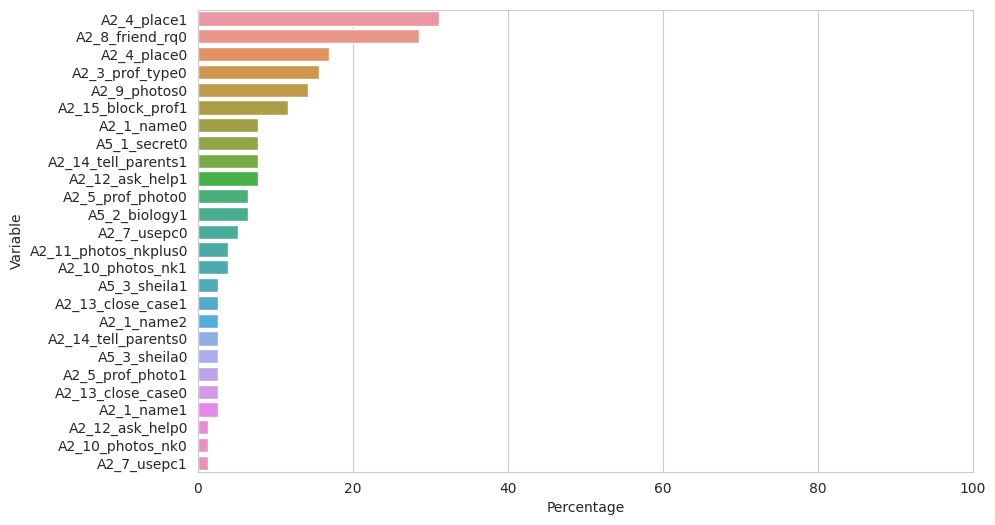

In [26]:
plot_var_count(df=df_q_2_join, var='P(Riksy|Evidence)', threshold=0.14)

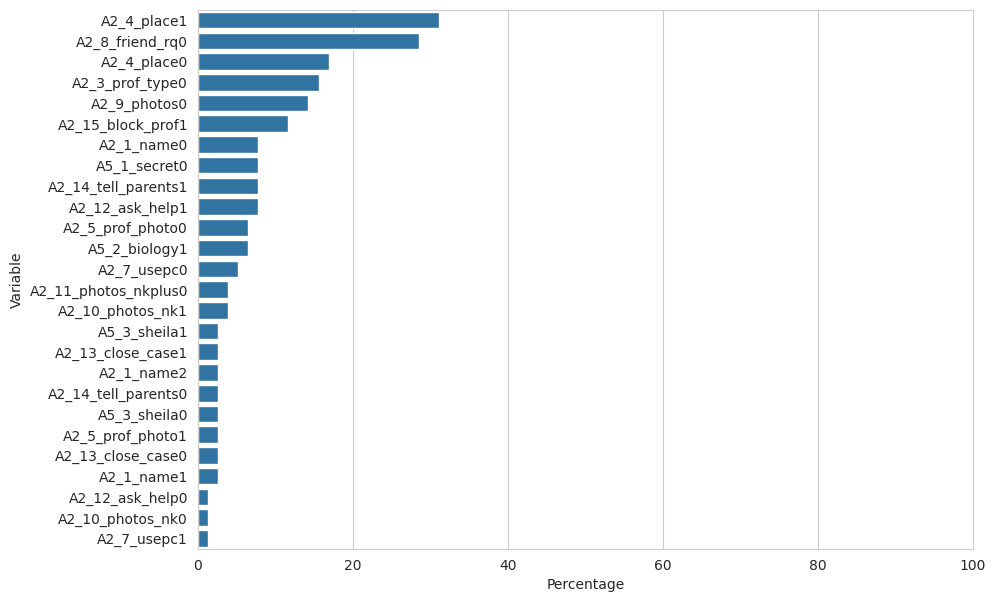

In [27]:
plot_var_count_elegant(df=df_q_2_join, var='P(Riksy|Evidence)', threshold=0.14)

### 3 variable analysis


In [28]:
df_q_3_join_ = compute_rank_evidencesv2(3, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_3_join = df_q_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_4_place3, A2_8_friend_rq2, A2_9_photos1)",0.019828,0.268212,0.007393
"(A2_4_place3, A2_5_prof_photo1, A2_9_photos1)",0.007426,0.095081,0.007810
"(A2_4_place3, A2_5_prof_photo0, A2_9_photos1)",0.008888,0.103859,0.008558
"(A2_4_place3, A2_5_prof_photo1, A2_8_friend_rq2)",0.007138,0.082533,0.008648
"(A2_11_photos_nkplus1, A2_4_place3, A2_9_photos1)",0.013281,0.153454,0.008654
...,...,...,...
"(A2_3_prof_type0, A2_4_place1, A2_9_photos0)",0.074989,0.020164,0.371899
"(A2_3_prof_type0, A2_4_place1, A2_5_prof_photo0)",0.055509,0.014473,0.383536
"(A2_4_place1, A2_5_prof_photo0, A2_8_friend_rq0)",0.052105,0.013578,0.383759
"(A2_3_prof_type0, A2_4_place1, A2_8_friend_rq0)",0.073219,0.018065,0.405316


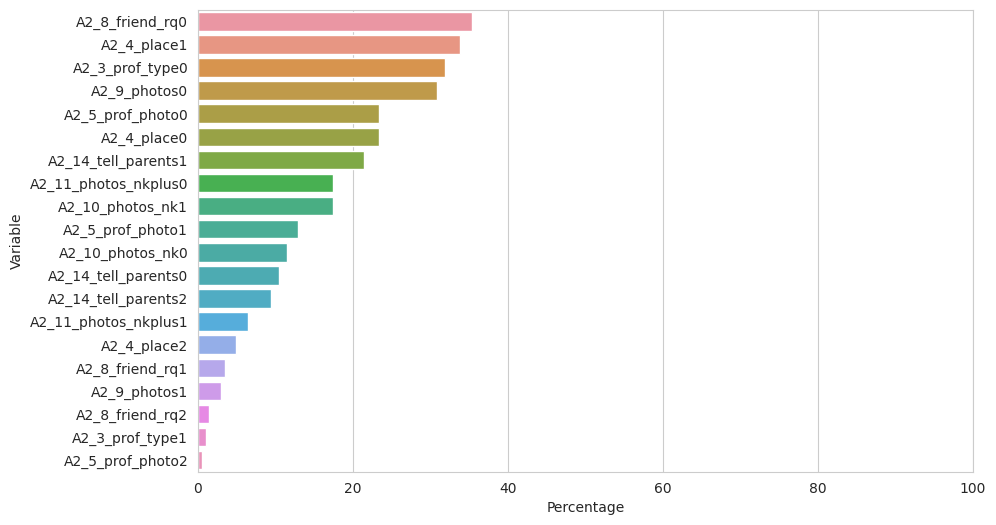

In [29]:
plot_var_count(df=df_q_3_join, var='P(Riksy|Evidence)', threshold=0.14)

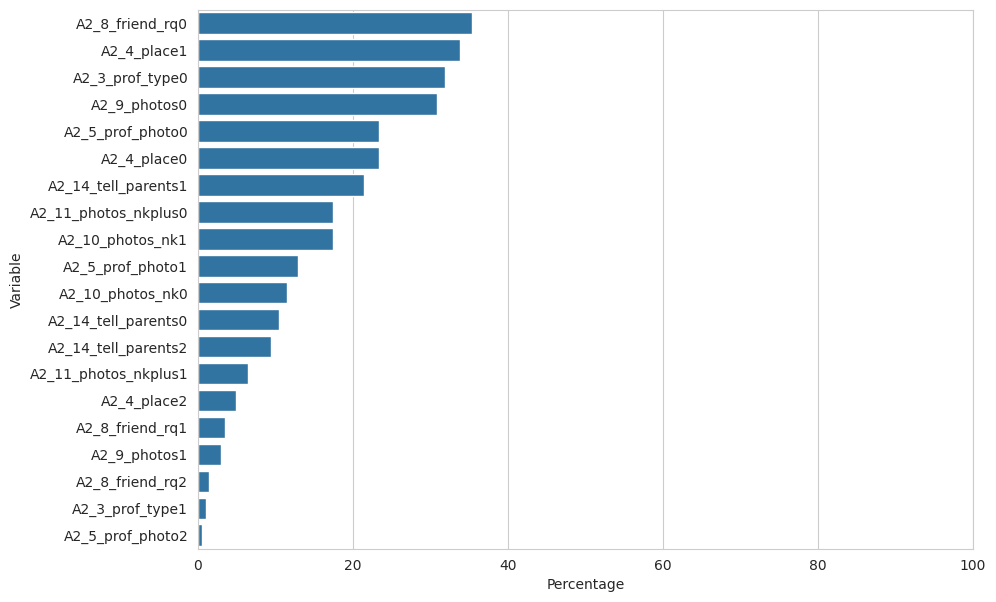

In [30]:
plot_var_count_elegant(df=df_q_3_join, var='P(Riksy|Evidence)', threshold=0.14)

### 4 variable analysis


In [31]:
df_q_4_join_ = compute_rank_evidencesv2(4, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_4_join = df_q_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_4_place3, A2_5_prof_photo1, A2_8_friend_rq2, A2_9_photos1)",0.003298,0.064184,0.005138
"(A2_4_place3, A2_5_prof_photo0, A2_8_friend_rq2, A2_9_photos1)",0.003738,0.071702,0.005214
"(A2_3_prof_type1, A2_4_place3, A2_5_prof_photo0, A2_9_photos1)",0.004428,0.081564,0.005428
"(A2_3_prof_type1, A2_4_place3, A2_5_prof_photo1, A2_9_photos1)",0.004168,0.074264,0.005613
"(A2_11_photos_nkplus1, A2_4_place3, A2_5_prof_photo1, A2_9_photos1)",0.002183,0.036318,0.006010
...,...,...,...
"(A2_10_photos_nk1, A2_14_tell_parents1, A2_4_place1, A2_8_friend_rq0)",0.013068,0.002628,0.497294
"(A2_10_photos_nk1, A2_3_prof_type0, A2_4_place1, A2_9_photos0)",0.029423,0.005855,0.502524
"(A2_10_photos_nk1, A2_4_place1, A2_8_friend_rq0, A2_9_photos0)",0.027637,0.005421,0.509789
"(A2_10_photos_nk1, A2_4_place1, A2_5_prof_photo0, A2_8_friend_rq0)",0.020515,0.003938,0.520960


In [32]:
df_q_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A2_4_place3, A2_5_prof_photo1, A2_8_friend_rq2, A2_9_photos1)",0.003298,0.064184,0.005138
"(A2_4_place3, A2_5_prof_photo0, A2_8_friend_rq2, A2_9_photos1)",0.003738,0.071702,0.005214
"(A2_3_prof_type1, A2_4_place3, A2_5_prof_photo0, A2_9_photos1)",0.004428,0.081564,0.005428
"(A2_3_prof_type1, A2_4_place3, A2_5_prof_photo1, A2_9_photos1)",0.004168,0.074264,0.005613
"(A2_11_photos_nkplus1, A2_4_place3, A2_5_prof_photo1, A2_9_photos1)",0.002183,0.036318,0.006010
...,...,...,...
"(A2_10_photos_nk1, A2_14_tell_parents1, A2_4_place1, A2_8_friend_rq0)",0.013068,0.002628,0.497294
"(A2_10_photos_nk1, A2_3_prof_type0, A2_4_place1, A2_9_photos0)",0.029423,0.005855,0.502524
"(A2_10_photos_nk1, A2_4_place1, A2_8_friend_rq0, A2_9_photos0)",0.027637,0.005421,0.509789
"(A2_10_photos_nk1, A2_4_place1, A2_5_prof_photo0, A2_8_friend_rq0)",0.020515,0.003938,0.520960


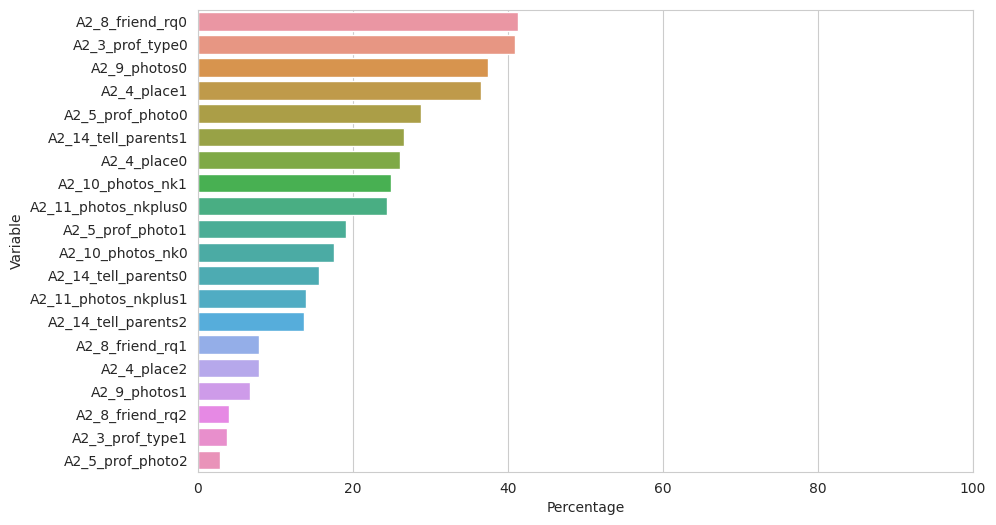

In [33]:
plot_var_count(df=df_q_4_join, var='P(Riksy|Evidence)', threshold=0.14)

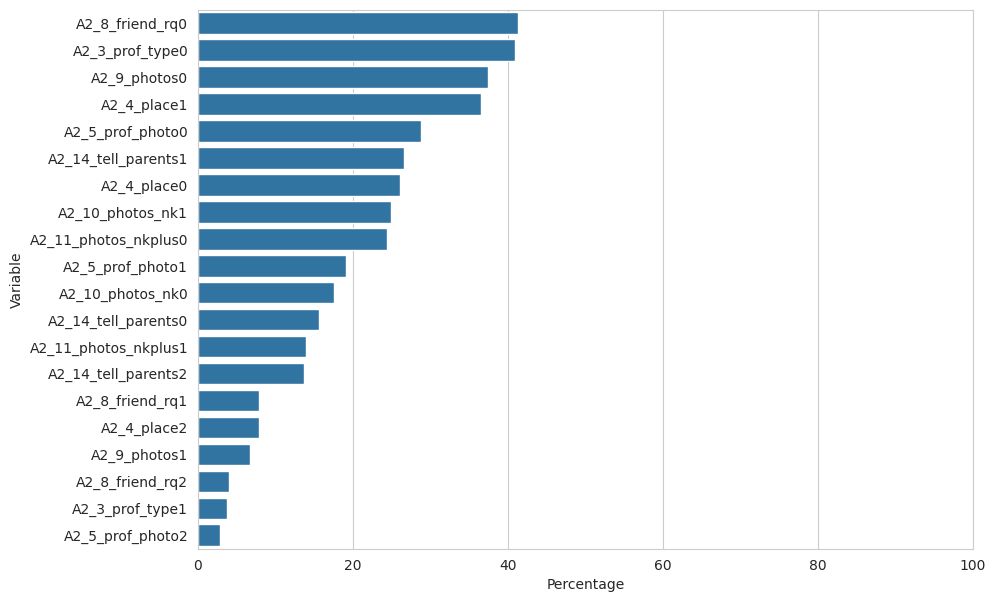

In [34]:
plot_var_count_elegant(df=df_q_4_join, var='P(Riksy|Evidence)', threshold=0.14)

### 5 variable analysis


In [ ]:
df_q_5_join_ = compute_rank_evidencesv2(5, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_5_join = df_q_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_5_join

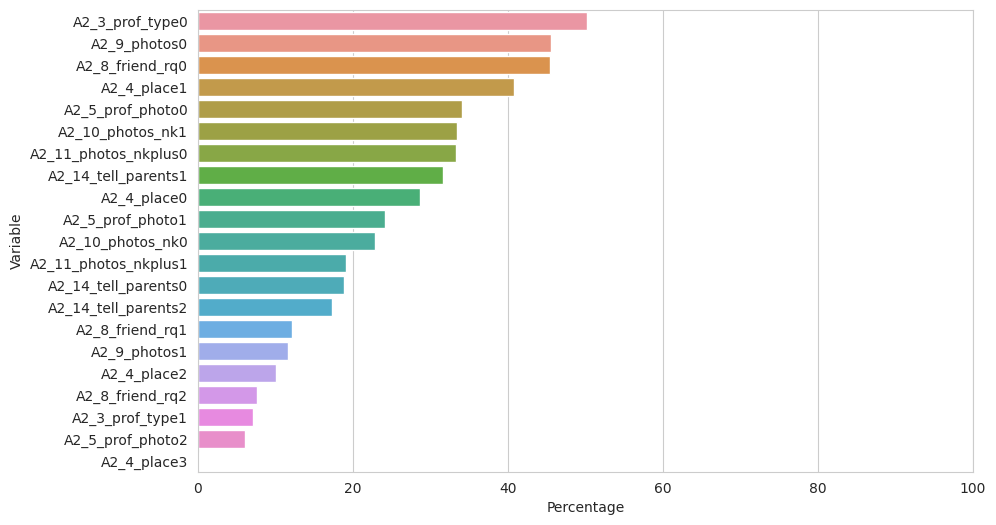

In [ ]:
plot_var_count(df=df_q_5_join, var='P(Riksy|Evidence)', threshold=0.14)

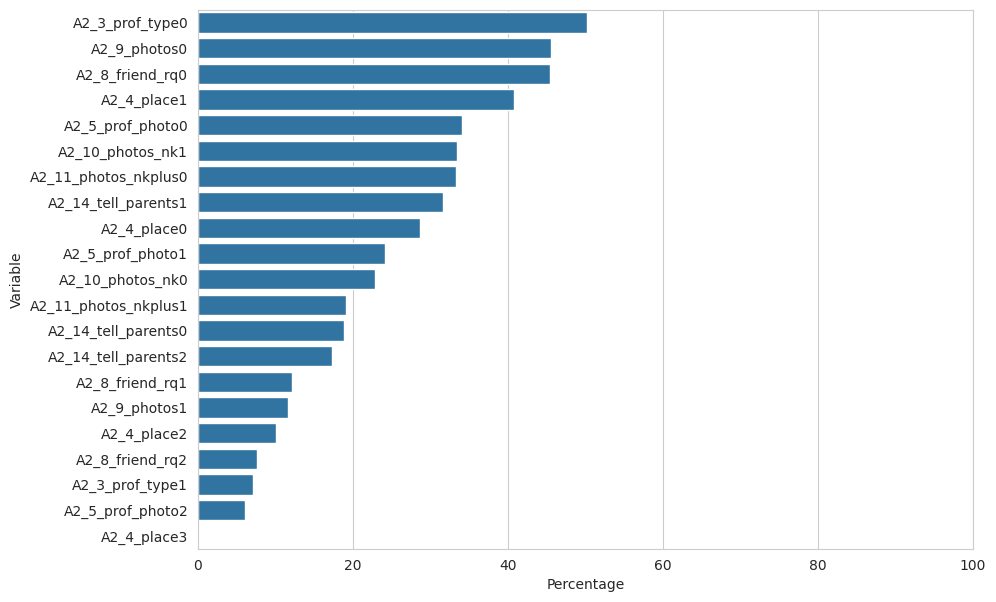

In [ ]:
plot_var_count_elegant(df=df_q_5_join, var='P(Riksy|Evidence)', threshold=0.14)

### 6 variable analysis


In [ ]:
df_q_6_join_ = compute_rank_evidencesv2(6, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_6_join = df_q_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_6_join

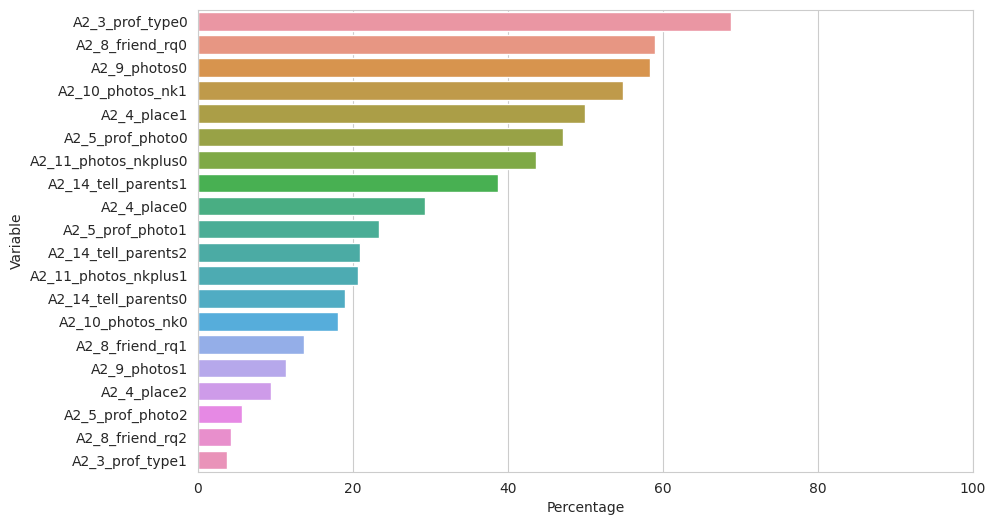

In [ ]:
plot_var_count(df=df_q_6_join, var='P(Riksy|Evidence)', threshold=0.25)

### 7 variable analysis

In [ ]:
df_q_7_join_ = compute_rank_evidencesv2(7, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_7_join = df_q_7_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_7_join

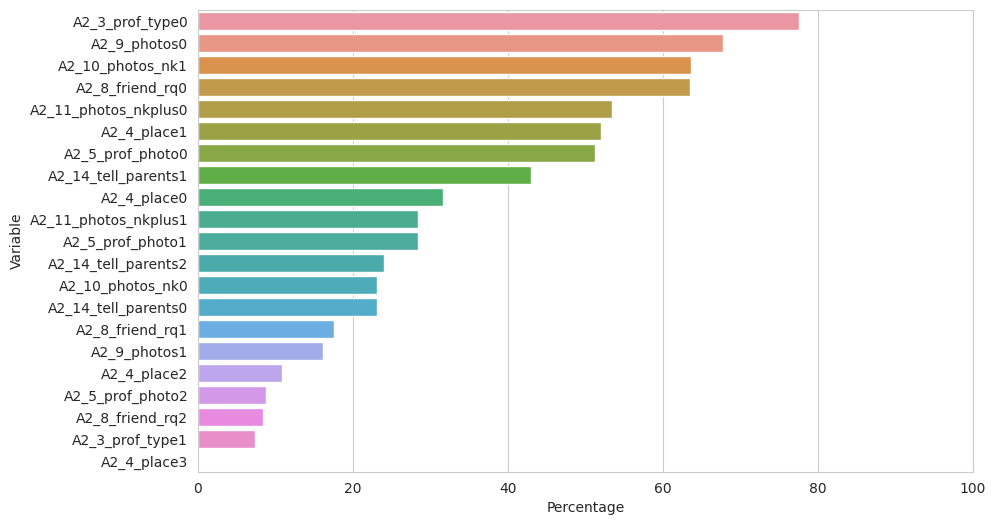

In [ ]:
plot_var_count(df=df_q_7_join, var='P(Riksy|Evidence)', threshold=0.25)

### 8 variable analysis

In [ ]:
df_q_8_join_ = compute_rank_evidencesv2(8, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_8_join = df_q_8_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_8_join

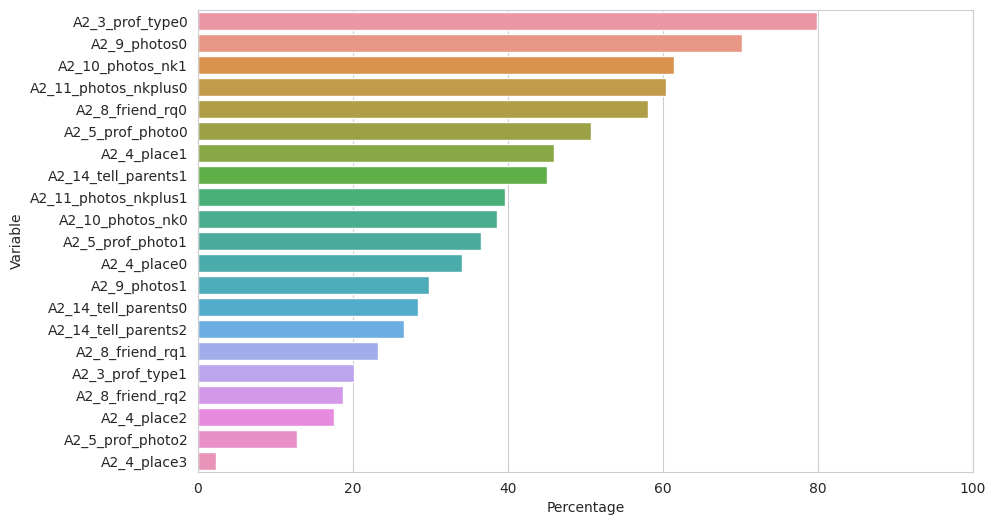

In [ ]:
plot_var_count(df=df_q_8_join, var='P(Riksy|Evidence)', threshold=0.14)

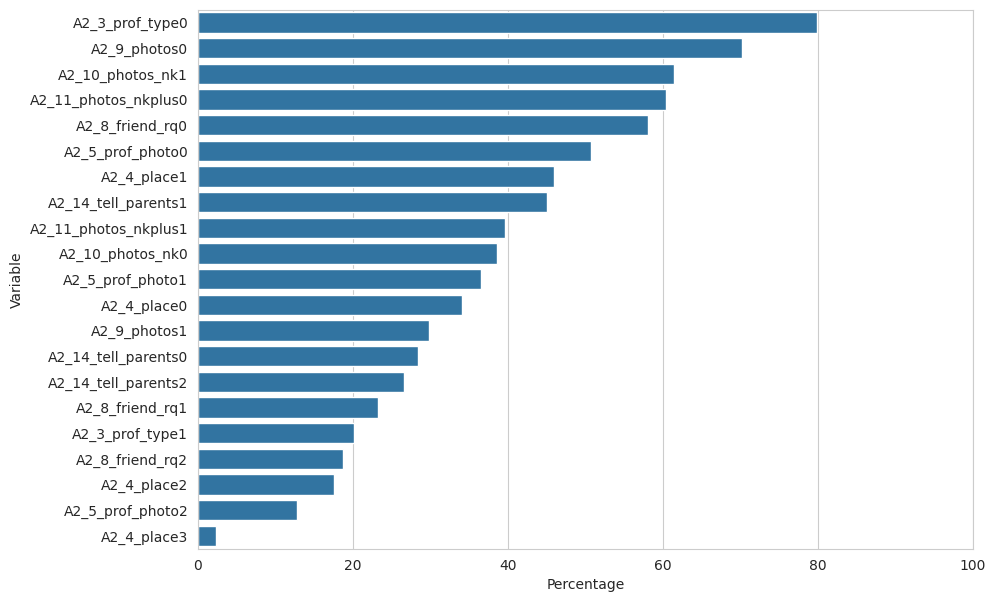

In [ ]:
plot_var_count_elegant(df=df_q_8_join, var='P(Riksy|Evidence)', threshold=0.14)

9 variable analysis

In [ ]:
df_q_9_join_ = compute_rank_evidencesv2(9, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_9_join = df_q_9_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_9_join

In [ ]:
plot_var_count(df=df_q_9_join, var='P(Riksy|Evidence)', threshold=0.25)

10 variable analysis

In [ ]:
df_q_10_join_ = compute_rank_evidencesv2(10, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_10_join = df_q_10_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_10_join

In [ ]:
plot_var_count(df=df_q_10_join, var='P(Riksy|Evidence)', threshold=0.25)

# 11 variable analysis

In [ ]:
df_q_11_join_ = compute_rank_evidencesv2(11, dict_val_game_OGv2, network_file_OG, var_interest_OG)
df_q_11_join = df_q_11_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_11_join

In [ ]:
plot_var_count(df=df_q_11_join, var='P(Riksy|Evidence)', threshold=0.25)

12 variable analysis

In [ ]:
df_q_12_join_ = compute_rank_evidencesv2(12, dict_val_game_OG, network_file_OG, var_interest_OG)
df_q_12_join = df_q_10_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_12_join

In [ ]:
plot_var_count(df=df_q_12_join, var='P(Riksy|Evidence)', threshold=0.25)

12+1 variable analysis

In [ ]:
df_q_13_join_ = compute_rank_evidencesv2(13, dict_val_game_OG, network_file_OG, var_interest_OG)
df_q_13_join = df_q_13_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_13_join

In [ ]:
plot_var_count(df=df_q_13_join, var='P(Riksy|Evidence)', threshold=0.25)

14 variable analysis

In [ ]:
df_q_14_join_ = compute_rank_evidencesv2(14, dict_val_game_OG, network_file_OG, var_interest_OG)
df_q_14join = df_q_14_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_14_join

In [ ]:
plot_var_count(df=df_q_14_join, var='P(Riksy|Evidence)', threshold=0.25)

## Demographics


In [ ]:
dict_val = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Sexual_Orientation': [0,1],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Self_Esteem': [0,1,2],
           'Empathy': [0,1],
           'Previous_Victimization': [0,1]
           }

dict_val_CT  = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_FN = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_OG = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Sexual_Orientation': [0,1],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Self_Esteem': [0,1,2],
           'Introversion_BF': [0,1,2],
           'Openness2Experience_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

### 1 variable analysis

In [ ]:
df_1_join_ = compute_rank_evidencesv2(1, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_1_join = df_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty0,)",0.065716,0.171779,0.038256
"(Gender2,)",0.020000,0.040000,0.049999
"(Family_Support0,)",0.044617,0.089178,0.050031
"(Hours_Internet4,)",0.041338,0.082591,0.050051
"(Neuroticism_BF2,)",0.065231,0.130212,0.050096
"(Sexual_Orientation1,)",0.087921,0.175441,0.050114
"(Social_Support0,)",0.036025,0.071885,0.050115
"(Agreeableness_BF2,)",0.070734,0.140957,0.050181
"(Migratory_background1,)",0.069260,0.137887,0.050229
"(Gender1,)",0.241235,0.480000,0.050257


### 2 variables analysis

In [ ]:
df_2_join_ = compute_rank_evidencesv2(2, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_2_join = df_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Gender2, Honesty0)",0.002581,0.006873,0.037551
"(Family_Support0, Honesty0)",0.005757,0.015322,0.037575
"(Honesty0, Hours_Internet4)",0.005334,0.014191,0.037590
"(Honesty0, Neuroticism_BF2)",0.008417,0.022373,0.037624
"(Honesty0, Sexual_Orientation1)",0.011345,0.030144,0.037638
...,...,...,...
"(Family_Support2, Honesty3)",0.073720,0.129065,0.057119
"(Honesty3, Hours_Internet2)",0.034044,0.059595,0.057126
"(Honesty3, Openness2Experience_BF0)",0.055006,0.096219,0.057168
"(Honesty3, Self_Esteem2)",0.042659,0.074581,0.057198


### 3 variables analysis

In [ ]:
df_3_join_ = compute_rank_evidencesv2(3, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_3_join = df_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Honesty0, Openness2Experience_BF2)",0.002348,0.006268,0.037451
"(Age3, Gender1, Honesty0)",0.006183,0.016495,0.037481
"(Age3, Agreeableness_BF2, Honesty0)",0.001816,0.004844,0.037496
"(Age0, Honesty0, Neuroticism_BF0)",0.004863,0.012967,0.037501
"(Honesty0, Hours_Internet2, Neuroticism_BF2)",0.002448,0.006526,0.037507
...,...,...,...
"(Agreeableness_BF0, Gender0, Honesty3)",0.024440,0.041975,0.058224
"(Gender0, Honesty3, Neuroticism_BF1)",0.028138,0.048298,0.058260
"(Gender0, Honesty3, Openness2Experience_BF0)",0.026916,0.046190,0.058271
"(Gender0, Honesty3, Self_Esteem2)",0.020901,0.035804,0.058377


### 4 variables analysis

In [ ]:
df_4_join_ = compute_rank_evidencesv2(4, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_4_join = df_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Honesty0, Hours_Internet1, Neuroticism_BF0)",0.001466,0.003937,0.037251
"(Age0, Honesty0, Introversion_BF1, Neuroticism_BF0)",0.001802,0.004834,0.037272
"(Age3, Gender1, Honesty0, Neuroticism_BF1)",0.003030,0.008124,0.037296
"(Gender1, Honesty0, Hours_Internet2, Openness2Experience_BF1)",0.003088,0.008277,0.037313
"(Age0, Honesty0, Migratory_background0, Openness2Experience_BF2)",0.001463,0.003919,0.037334
...,...,...,...
"(Gender0, Honesty3, Openness2Experience_BF0, Self_Esteem2)",0.010099,0.016865,0.059884
"(Gender0, Honesty3, Neuroticism_BF1, Openness2Experience_BF0)",0.013636,0.022751,0.059937
"(Gender0, Honesty3, Hours_Internet1, Self_Esteem2)",0.005074,0.008448,0.060067
"(Gender0, Honesty3, Hours_Internet2, Neuroticism_BF1)",0.008630,0.014335,0.060205


### 5 variables analysis

In [ ]:
df_5_join_ = compute_rank_evidencesv2(5, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_5_join = df_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_5_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age1, Agreeableness_BF1, Honesty0, Hours_Internet1, Introversion_BF1)",0.000556,0.001516,0.036649
"(Age0, Honesty0, Hours_Internet1, Introversion_BF1, Neuroticism_BF0)",0.000571,0.001550,0.036849
"(Age0, Agreeableness_BF1, Honesty0, Hours_Internet1, Self_Esteem1)",0.000701,0.001901,0.036860
"(Agreeableness_BF1, Honesty0, Hours_Internet1, Introversion_BF1, Neuroticism_BF0)",0.000899,0.002436,0.036892
"(Age2, Agreeableness_BF1, Gender0, Honesty0, Introversion_BF0)",0.001169,0.003164,0.036951
...,...,...,...
"(Age1, Gender0, Hours_Internet1, Introversion_BF1, Self_Esteem2)",0.002509,0.003787,0.066252
"(Age1, Agreeableness_BF0, Honesty3, Hours_Internet1, Introversion_BF1)",0.001187,0.001792,0.066269
"(Age4, Agreeableness_BF1, Hours_Internet0, Neuroticism_BF0, Self_Esteem2)",0.000872,0.001313,0.066453
"(Age1, Agreeableness_BF0, Gender0, Hours_Internet1, Self_Esteem2)",0.002833,0.004144,0.068351


In [ ]:
plot_var_count(df=df_5_join, var='P(Riksy|Evidence)', threshold=0.14)

ValueError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
# all_indexes = []
# for i in df_5_join[df_5_join['P(Riksy|Evidence)']>0.25].index:
#   all_indexes.extend(i)

# len_df_filtered = len(df_5_join[df_5_join['P(Riksy|Evidence)']>0.25])
# lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
# df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
# df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

# lst_vars = ['Previous_Victimization = True',
#             'Gender = Male',
#             'Self-Esteem = High',
#             'Hours of Internet = 3-4 h',
#             'Age = 14',
#             'Age = 16',
#             'Age = 13',
#             'Hours of Internet = >4 h',
#             'Empathy = High',
#             'Family Support = High',
#             'Empathy = Low',
#             'Self-Esteem = Low',
#             'Self-Esteem = Medium',
#             'Hours of Internet = <1 h',
#             'Social Support = High',
#             'Social Support = Medium',
#             'Hours of Internet = 2-3 h',
#             'Family Support = Medium',
#             'Age = 15',
#             'Family Support = Low',
#             'Social Support = Low',
#             'Migratory Background = False',
#             'Sexual Orientation = Heterosexual',
#             'Age = 12',
#             'Gender = Female',
#             'Hours of Internet = 1-2 h'
#             ]


# plt.figure(figsize=(10, 6))
# sns.barplot(data=df_count, x='Percentage', y=lst_vars, color='tab:blue')
# plt.xlim((0,100))

# plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
# plt.show()
# plt.show()

### 6 variables analysis

In [ ]:
df_6_join_ = compute_rank_evidencesv2(6, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_6_join = df_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_6_join

In [ ]:
plot_var_count(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.14)

### 7 variables analysis

In [ ]:
df_7_join_ = compute_rank_evidencesv2(7, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_7_join = df_7_join_.sort_values(by=['P(Riksy|Evidence)'])
df_7_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0)",0.001057,0.000908,0.116459
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0)",0.001786,0.001438,0.124218
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001390,0.001083,0.128366
"(Age3, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.002513,0.001915,0.131254
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001246,0.000929,0.134140
...,...,...,...
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Honesty0, Neuroticism_BF1, Social_Support0)",0.000247,0.000034,0.725020
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0)",0.000639,0.000088,0.726475
"(Age3, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.003777,0.000519,0.727002
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Social_Support2)",0.001054,0.000143,0.735622


In [ ]:
plot_var_count(df=df_7_join, var='P(Riksy|Evidence)', threshold=0.14)

### 8 variables analysis

In [ ]:
df_8_join_ = compute_rank_evidencesv2(8, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_8_join = df_8_join_.sort_values(by=['P(Riksy|Evidence)'])
df_8_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000436,0.000466,0.093613
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender1, Honesty2, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000582,0.000573,0.101575
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.000841,0.000822,0.102293
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.001408,0.001357,0.103803
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0)",0.000734,0.000707,0.103939
...,...,...,...
"(Age3, Agreeableness_BF1, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.001751,0.000229,0.765969
"(Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Gender0, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000081,0.000011,0.768701
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000156,0.000020,0.768787
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000442,0.000057,0.773196


In [ ]:
plot_var_count(df=df_8_join, var='P(Riksy|Evidence)', threshold=0.14)

### 9 variables analysis

In [ ]:
df_9_join_ = compute_rank_evidencesv2(9, dict_val_OG,
                                      network_file_OG, var_interest_OG)
df_9_join = df_9_join_.sort_values(by=['P(Riksy|Evidence)'])
df_9_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Honesty2, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000303,0.000442,0.068455
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000302,0.000403,0.074862
"(Age2, Agreeableness_BF1, Conscientiousness_BF2, Family_Support2, Gender0, Honesty2, Hours_Internet3, Neuroticism_BF0, Social_Support2)",0.000113,0.000140,0.080806
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Family_Support2, Gender1, Honesty3, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.000222,0.000271,0.081637
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Family_Support2, Gender1, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.000051,0.000057,0.087918
...,...,...,...
"(Age1, Agreeableness_BF0, Conscientiousness_BF1, Family_Support1, Gender1, Honesty0, Hours_Internet0, Neuroticism_BF1, Social_Support0)",0.000163,0.000020,0.812706
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Family_Support0, Gender1, Honesty0, Hours_Internet1, Neuroticism_BF1, Social_Support0)",0.000051,0.000006,0.815359
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Family_Support1, Gender0, Honesty0, Hours_Internet2, Neuroticism_BF0, Social_Support1)",0.000208,0.000025,0.815995
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Family_Support2, Gender0, Honesty0, Hours_Internet1, Neuroticism_BF0, Social_Support1)",0.000734,0.000088,0.835340


In [ ]:
plot_var_count(df=df_9_join, var='P(Riksy|Evidence)', threshold=0.14)

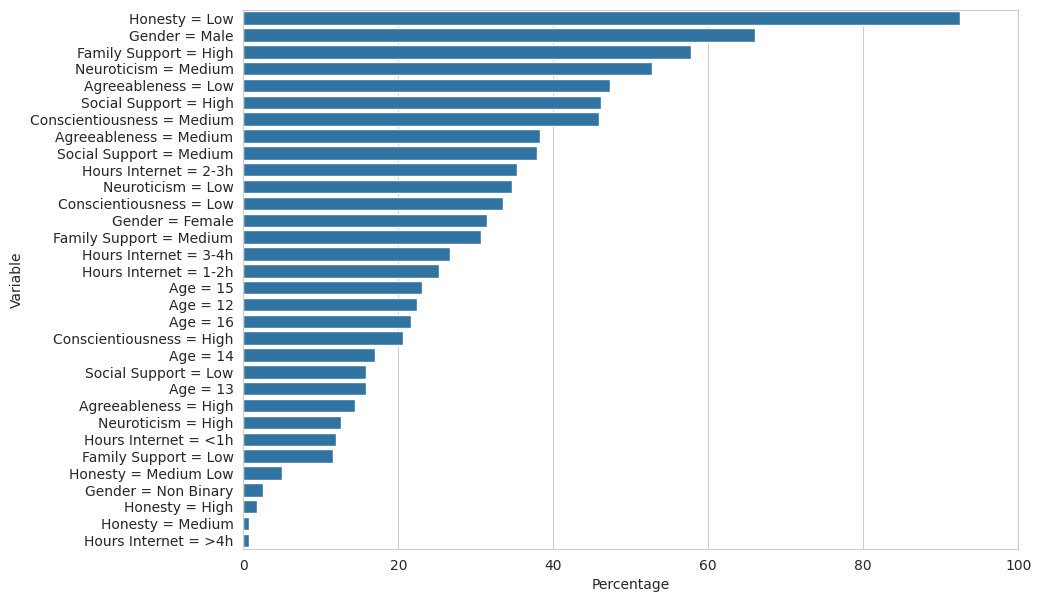

In [ ]:
plot_var_count_elegant(df=df_9_join,var='P(Riksy|Evidence)', threshold=0.57)

# Plot

## Max P(Riksy|Evidence) // Nº Var

In [ ]:
q_max = []
for i in range(1, 9):
  q_max.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_q = {'Max': q_max,
          'Data Type': ['Game Questions']*8,
          'vars': list(range(1, 9))}

q_max_evidence = []
for i in range(1, 9):
  q_max_evidence.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_q_evidence = {'Max': q_max_evidence,
                  'Data Type': ['Game P(Evidence|Risky)']*8,
                  'vars': list(range(1, 9))}

In [ ]:
dict_q_evidence

{'Max': [0.14277281194499908,
  0.09658377595543087,
  0.03777531211125566,
  0.02860033739387479,
  0.01561859007014842,
  0.01168930321631198,
  0.0039648230386898665,
  0.0030652379300662464],
 'Data Type': ['Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)',
  'Game P(Evidence|Risky)'],
 'vars': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
dem_max = []
for i in range(1, 10):
  dem_max.append(float(globals()[f'df_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_dem = {'Max': dem_max,
            'Data Type': ['Profiling']*9,
            'vars': list(range(1, 10))}

dem_max_evidence = []
for i in range(1, 10):
  dem_max_evidence.append(float(globals()[f'df_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_dem_evidence = {'Max': dem_max_evidence,
                    'Data Type': ['Profiling P(Evidence|Risky)']*9,
                    'vars': list(range(1, 10))}

In [ ]:
dict_dem

{'Max': [0.5095019142820999,
  0.5173305382404895,
  0.5298538733434174,
  0.5456118094383764,
  0.5982509199695246,
  0.6762426684157838,
  0.7535886377852551,
  0.8281961199975796,
  0.8502102434034206],
 'Data Type': ['Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling'],
 'vars': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [ ]:
df_max = pd.concat([pd.DataFrame(dict_q),
                    # pd.DataFrame(dict_q_evidence),
                    pd.DataFrame(dict_dem),
                    # pd.DataFrame(dict_dem_evidence)
                    ], ignore_index=True)
df_max

,Max,Data Type,vars
0,0.166492,Game Questions,1
1,0.301794,Game Questions,2
2,0.414718,Game Questions,3
3,0.561659,Game Questions,4
4,0.650958,Game Questions,5
5,0.703562,Game Questions,6
6,0.734197,Game Questions,7
7,0.755319,Game Questions,8
8,0.509502,Profiling,1
9,0.517331,Profiling,2


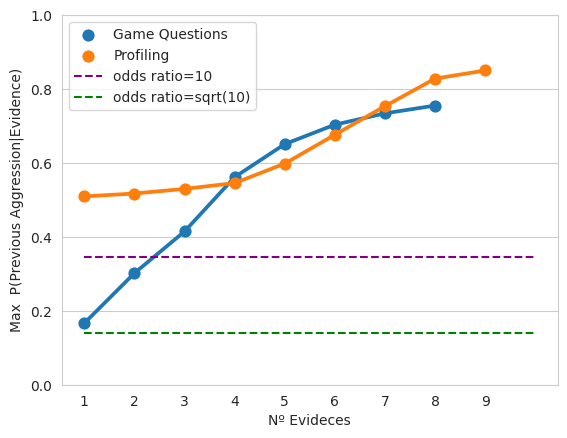

In [ ]:
sns.pointplot(df_max, x='vars', y='Max', hue='Data Type')
plt.ylabel('Max  P(Previous Aggression|Evidence)')
plt.hlines(0.345, 0, 9, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.14, 0, 9, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.xlabel('Nº Evideces')
plt.ylim((0,1))
plt.legend(loc='upper left')
plt.savefig("Analysis2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
df_max_2 = pd.concat([pd.DataFrame(dict_q),
                    pd.DataFrame(dict_dem)], ignore_index=True)
df_max_2

,Max,Data Type,vars
0,0.166492,Game Questions,1
1,0.301794,Game Questions,2
2,0.414718,Game Questions,3
3,0.561659,Game Questions,4
4,0.650958,Game Questions,5
5,0.703562,Game Questions,6
6,0.734197,Game Questions,7
7,0.755319,Game Questions,8
8,0.509502,Profiling,1
9,0.517331,Profiling,2


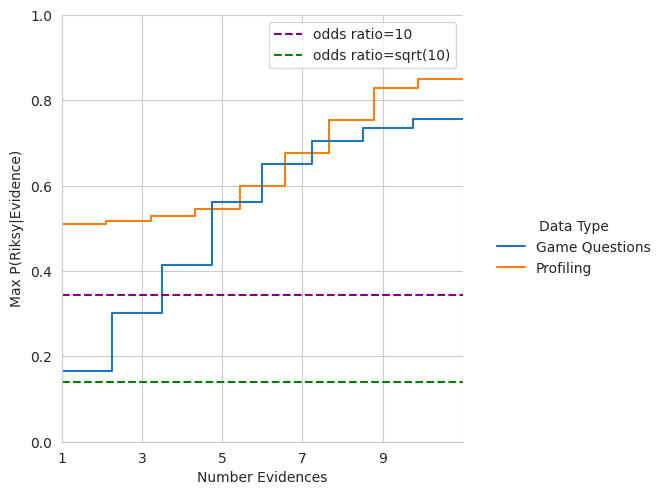

In [ ]:
sns.displot(df_max_2, y='Max', hue='Data Type', kind='ecdf')
plt.hlines(0.345, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.14, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence)')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, '']
plt.xticks(ticks, labels)
plt.legend()
plt.savefig("Analysis2_stair.pdf", format="pdf", bbox_inches="tight")

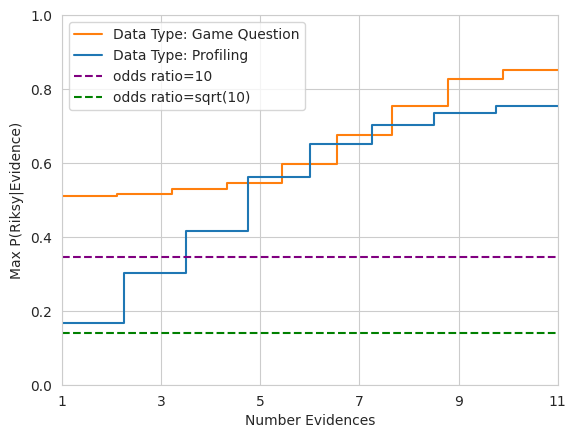

In [ ]:
sns.ecdfplot(df_max_2, y='Max', hue='Data Type')
plt.hlines(0.345, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.14, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence)')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, 11]
plt.xticks(ticks, labels)
plt.legend(['Data Type: Game Question', 'Data Type: Profiling', 'odds ratio=10', 'odds ratio=sqrt(10)'])
plt.savefig("Analysis2_stair.pdf", format="pdf", bbox_inches="tight")

## Max P(Evidence|Riksy) // Nº Var

In [ ]:
q_max_2 = []
for i in range(1, 7):
  q_max_2.append(float(globals()[f'df_q_{i}_join']['P(Evidence|Risky)'].max()))

dict_q_2 = {'Max': q_max_2,
          'Type': ['Game Question']*6,
          'vars': list(range(1, 7))}


In [ ]:
dem_max_2 = []
for i in range(1, 10):
  dem_max_2.append(float(globals()[f'df_{i}_join']['P(Evidence|Risky)'].max()))

dict_dem_2 = {'Max': dem_max_2,
            'Type': ['Demographic']*9,
            'vars': list(range(1, 10))}

In [ ]:
df_max_2 = pd.concat([pd.DataFrame(dict_q_2),
                    pd.DataFrame(dict_dem_2)], ignore_index=True)
df_max_2

,Max,Type,vars
0,0.384336,Game Question,1
1,0.282563,Game Question,2
2,0.185327,Game Question,3
3,0.135833,Game Question,4
4,0.083219,Game Question,5
5,0.044978,Game Question,6
6,1.922039,Demographic,1
7,1.079488,Demographic,2
8,0.587650,Demographic,3
9,0.296915,Demographic,4


(0.0, 1.0)

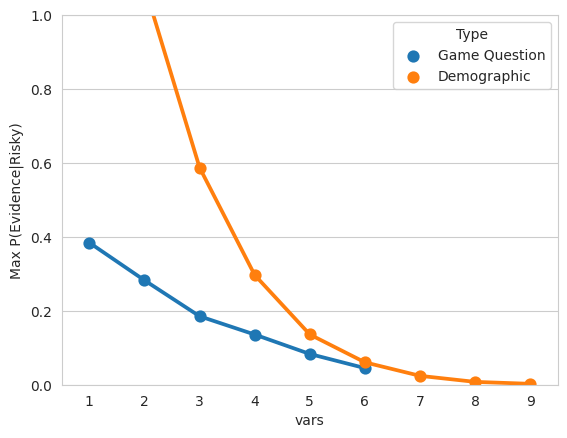

In [ ]:
sns.pointplot(df_max_2, x='vars', y='Max', hue='Type')
plt.ylabel('Max P(Evidence|Risky)')
plt.ylim((0,1))

## % risky // Nº Var

In [ ]:
threshold_risky = 0.25

In [ ]:
import math

In [ ]:
q_len = []
for i in range(1, 7):
  _df = globals()[f'df_q_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  q_len.append(len_risky/len_total)

dict_q_len = {'Percent': q_len,
          'Type': ['Game Question']*6}

In [ ]:
dem_len = []
for i in range(1, 10):
  _df = globals()[f'df_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  dem_len.append(len_risky/len_total)

dict_dem_len = {'Percent': dem_len,
          'Type': ['Demographic']*9}

In [ ]:
'''comb_max = []
for i in range(1, 11):
  comb_max.append(float(globals()[f'df_comb_{i}'].max()))

dict_comb = {'Max': comb_max,
            'Type': ['Combine']*10}'''

"comb_max = []\nfor i in range(1, 11):\n  comb_max.append(float(globals()[f'df_comb_{i}'].max()))\n\ndict_comb = {'Max': comb_max,\n            'Type': ['Combine']*10}"

In [ ]:
df_len = pd.concat([pd.DataFrame(dict_q_len), pd.DataFrame(dict_dem_len)], ignore_index=True)
df_len

,Percent,Type
0,0.000000,Game Question
1,0.007418,Game Question
2,0.055951,Game Question
3,0.075990,Game Question
4,0.091656,Game Question
5,0.102020,Game Question
6,0.937500,Demographic
7,0.889381,Demographic
8,0.844324,Demographic
9,0.792403,Demographic


(0.0, 1.0)

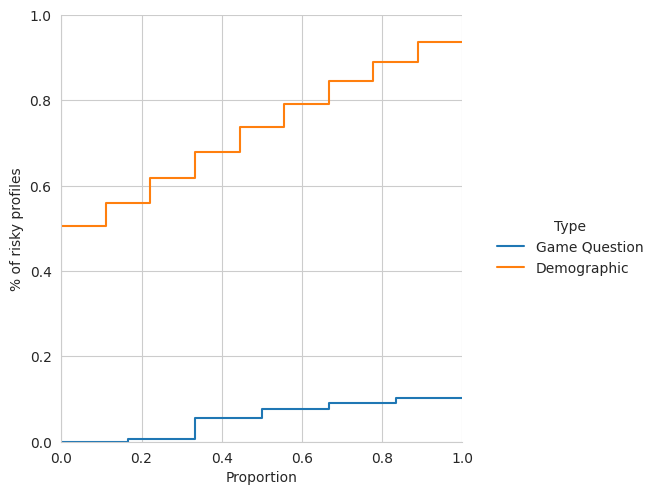

In [ ]:
sns.displot(df_len, y='Percent', hue='Type', kind='ecdf')
plt.ylabel('% of risky profiles')
plt.ylim((0,1))